In [1]:
import os
import sys
import json
import torch
import pickle
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from torch_geometric.data import Data, Batch
import help_functions as hf
from enum import IntEnum
import joblib

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn 
import help_functions as hf
import gnn_io as gio

<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [2]:
# Parameters to adapt
run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_21_10_2024/'
point_net_conv_layer_structure_local_mlp = "64,128"
point_net_conv_layer_structure_global_mlp = "256,64"
gat_conv_layer_structure = "128,256,512,256" 
# for new model, remove last 256
dropout = 0.3
use_dropout = False 
predict_mode_stats = False
in_channels = 13
out_channels = 1 

districts_of_interest =  [1, 2, 3, 4] 
test_data = "../../data/test_data/gdf_pop_1pm_policy_in_1_2_3_4.geojson"  # "../../data/test_data/gdf_pop_1pm_policy_in_5_6_7.geojson"
test_data = gpd.read_file(test_data) 

# The rest we can usually leave as is
loss_fct = torch.nn.MSELoss()
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
pnc_l_string = point_net_conv_layer_structure_local_mlp.replace(',', '_')
pnc_g_string = point_net_conv_layer_structure_global_mlp.replace(',', '_') 
gat_string = gat_conv_layer_structure.replace(',', '_')

unique_model_description = f"pnc_local_[{pnc_l_string}]_" + \
f"pnc_global_[{pnc_g_string}]_" + \
f"gat_conv_[{gat_string}]_" + \
f"use_dropout_{use_dropout}_" + \
f"dropout_{dropout}_" + \
f"predict_mode_stats_{predict_mode_stats}" + "/"
        
run_path = run_path + unique_model_description
base_case_path = '../../data/test_data/pop_1pm_basecase_mean_links_NEW.geojson'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

test_data.crs = "EPSG:2154"  # Assuming the original CRS is EPSG:2154
test_data.to_crs("EPSG:4326", inplace=True)

def prepare_gdf(test_df, base_case):
    gdf = base_case[['link', 'highway','geometry']].merge(test_df, on='link', how='left')
    gdf = gdf.drop(columns=['geometry_x'])
    gdf = gdf.rename(columns={'geometry_y': 'geometry'})
    return gdf

test_data_gdf = prepare_gdf(test_df=test_data, base_case=links_base_case)

In [3]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=66, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (point_net_conv_3): PointNetConv(local_nn=Sequential(
    (0)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
edge_start_point_tensor,stacked_edge_geometries_tensor, edges_base, nodes = hf.get_link_geometries(links_gdf_input=links_base_case)

test_input_linegraph = hf.create_test_object(links_base_case=links_base_case, test_data = test_data_gdf, stacked_edge_geometries_tensor=stacked_edge_geometries_tensor) 
normalized_x = hf.normalize_tensor(test_input_linegraph.x, scaler_x)
normalized_pos = hf.normalize_pos_features(test_input_linegraph.pos, scaler_pos)

normalized_data = Data(
    x=normalized_x,
    pos=normalized_pos,
    edge_index=test_input_linegraph.edge_index,
    edge_attr=test_input_linegraph.edge_attr,
    y=test_input_linegraph.y
)

test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, normalized_data, loss_fct, device)

print(f"Test Loss: {test_loss_my_test_data}")
print(f"R-squared: {r_squared_my_test_data}")
print(f"Baseline Loss: {baseline_loss_my_test_data}")

# Next, we visualize the perfomance on selected subsets.


/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:565: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(buffer)


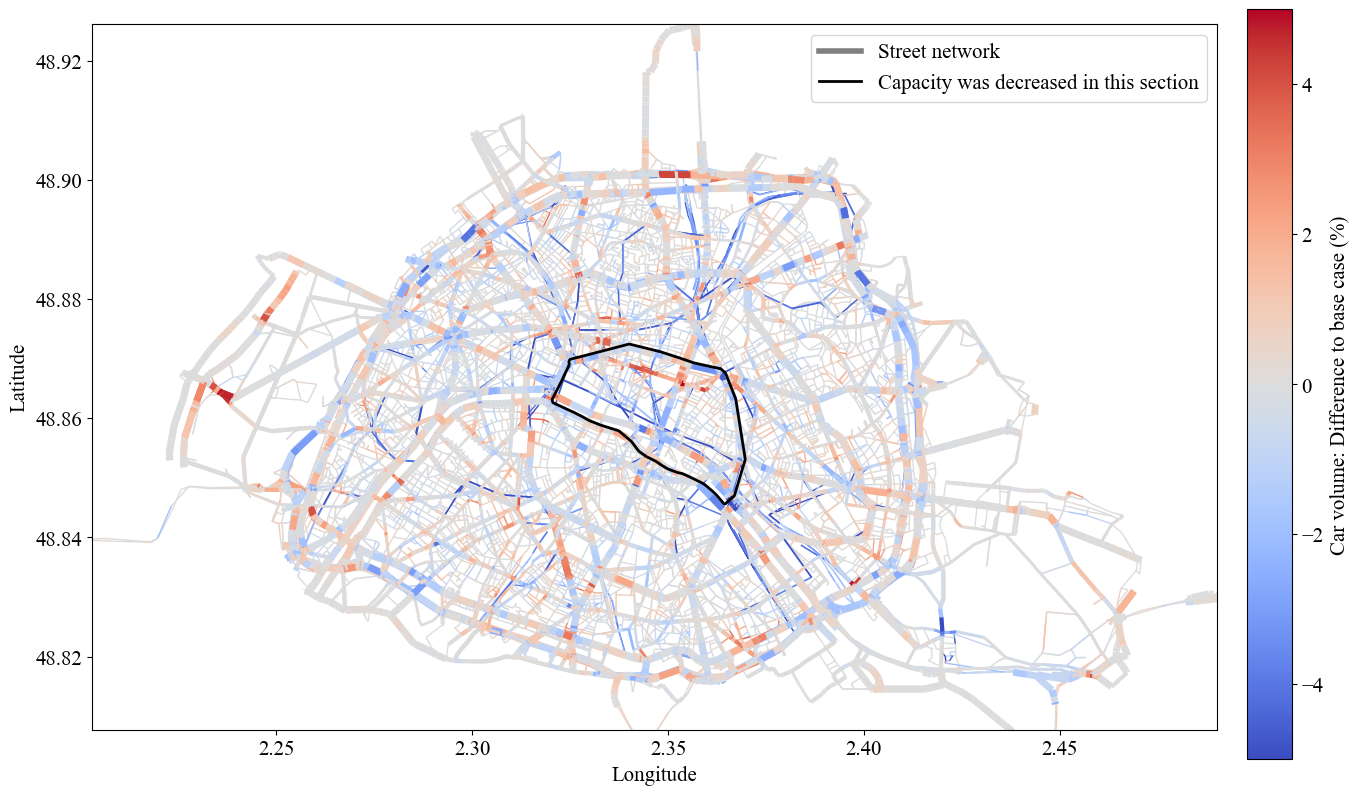

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:565: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(buffer)


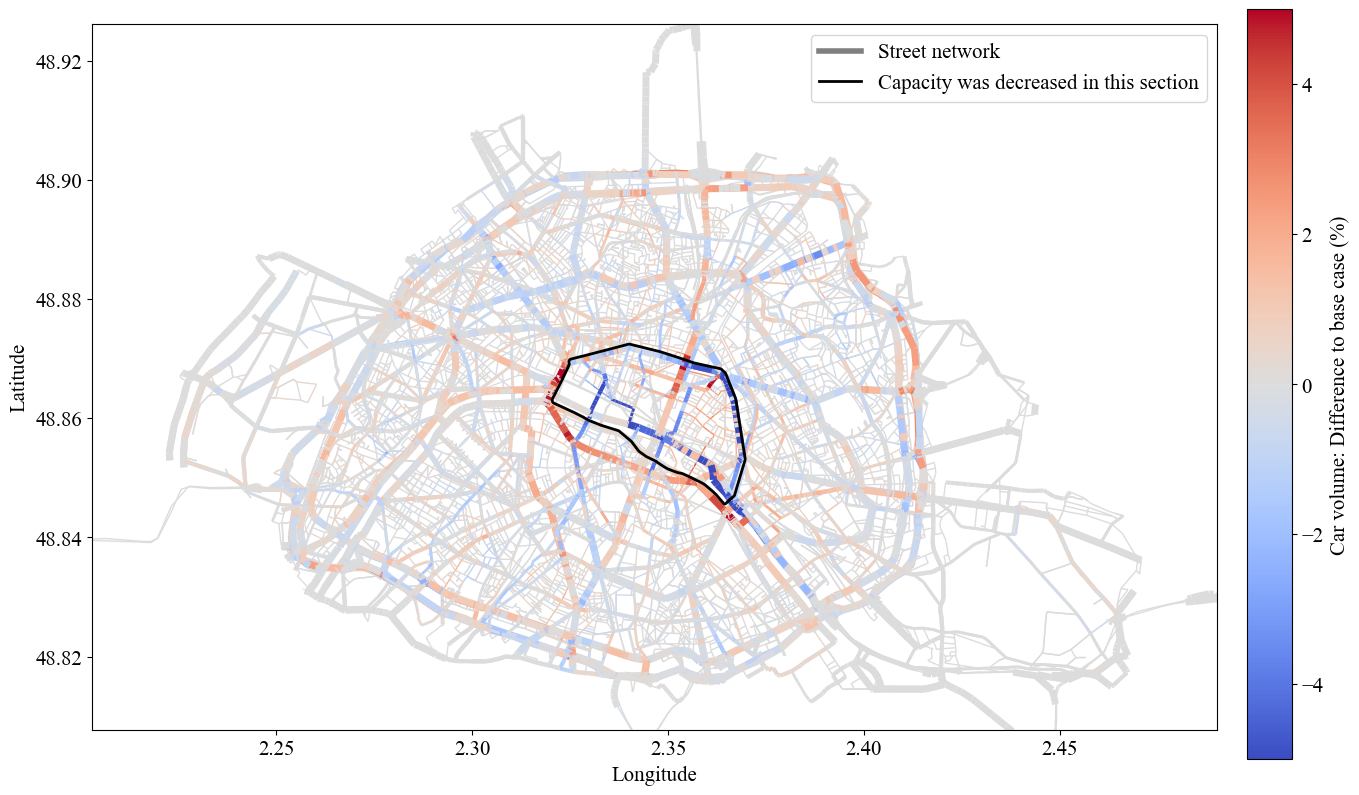

In [6]:
normalized_data_x = normalized_data.x
my_test_x = normalized_data_x.to('cpu')
inversed_x = scaler_x.inverse_transform(my_test_x)

gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=normalized_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

fixed_norm_max = 5

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                        save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = True, buffer = 0.0005, districts_of_interest=districts_of_interest)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=False, 
                        number_to_plot=None, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = True, buffer = 0.0005, districts_of_interest=districts_of_interest)